# Nhận diện gương mặt với khẩu trang

# 1. Sơ lược dự án

Một trong những ứng dụng phổ biến của Máy học là **Nhận diện gương mặt**. Ứng dụng này có mặt hầu như ở mọi mặt trong đời sống xã hội cũng như khoa học công nghệ, chúng ta sử dụng nhận diện gương mặt để chấm công nhân viên, sử dụng nhận diện gương mặt cho mục đích an ninh, ... Ở dự án này, chúng ta cũng sẽ tiến hành tạo ra một mô hình nâng cao hơn. Vẫn là mô hình **nhận diện gương mặt**, nhưng lần này chúng ta sẽ tiến hành thêm một bước sau khi đã nhận diện được một gương mặt từ tấm ảnh hay video, đó là xem thử liệu một khuôn mặt **có đeo khẩu trang hay không**. Việc này có ứng dụng rất lớn trong bối cảnh dịch bệnh Covid hiện nay, tiến hành phát hiện sớm một người không đeo khẩu trang có thể giảm thiểu mức độ lây nhiễm xuống thấp, qua đó góp phần thúc đẩy việc đẩy lùi dịch bệnh một cách nhanh chóng và ít tốn kém hơn. Tức là mô hình của chúng ta sẽ hoạt động như sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Chúng ta sẽ tạo ra mô hình ở **bước (3)** và sử dụng các mô hình nhận diện gương mặt có sẵn để tạo thành một pipeline hoàn chỉnh ở trên

Cụ thể, trong dự án này chúng ta sẽ thực hiện các bước sau:

1. Tạo ra một tập dữ liệu (bao gồm các gương mặt có và không có đeo khẩu trang) từ nhiều nguồn khác nhau.
2. Tiền xử lý dữ liệu
3. Chia tập dữ liệu dùng riêng cho mục đích huấn luyện và kiểm tra mô hình
4. Huấn luyện mô hình
5. Kiểm tra mô hình
6. Cải tiến

- Vẫn như các dự án máy học khác, điều đầu tiên chúng ta cần làm là import các thư viện cần thiết

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
%matplotlib inline

# 2. Khởi tạo tập dữ liệu

Lần này, dữ liệu sẽ không được cung cấp sẵn, bạn sẽ phải tự tạo ra một tập dữ liệu từ nhiều nguồn có sẵn và ghép chúng lại thành một tập dữ liệu duy nhất cho dự án này. 

1. Đầu tiên, bạn phải download các tập dữ liệu từ các nguồn sau đây

    - https://www.kaggle.com/andrewmvd/face-mask-detection
	- https://www.kaggle.com/omkargurav/face-mask-dataset
	- https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset
	- https://www.kaggle.com/vijaykumar1799/face-mask-detection
	- https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset
	- https://www.kaggle.com/spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask
	- https://www.kaggle.com/sumansid/facemask-dataset
	- https://drive.google.com/file/d/1m6Rd5nxol_cT2EKHSodli9HD1L6k0bKR/view
    
Bạn có thể thấy, các tập dữ liệu đã được chia nhỏ thành 2 thư mục riêng biệt, đó là **có đeo khẩu trang (with mask)** và **không đeo khẩu trang (without mask)**. Chúng có thể được chứa trong các thư mục lớn hơn nữa là train, validation và test; nhưng điều này không đáng kể, bạn chỉ cần lưu ý 2 thư mục đã nêu ở trên.

2. Bạn đem các ảnh tải được bỏ vào trong thư mục **dataset** theo cấu trúc sau:

```
dataset <- thư mục chứa ảnh dữ liệu cho dự án
└───with mask <- ảnh của các khuôn mặt có đeo khẩu trang được chứa trong thư mục này
│       1.jpg
│       ...
└───without mask <- ảnh của các khuôn mặt không có đeo khẩu trang được chứa trong thư mục này
│       2.jpg
│       ...         
```

**Lưu ý:** Có thể sẽ có một vài tấm ảnh bị trùng giữa các nguồn dữ liệu khác nhau, bạn chỉ cần bỏ qua quá trình sao chép các tấm ảnh bị trùng này vào tập **dataset** là được.

# 3. Tiền xử lý dữ liệu

- Sau khi đã tạo ra một tập dữ liệu hoàn chỉnh, bạn sẽ tiến hành biến dữ liệu thành dạng mà máy tính có thể xử lý được như đã làm trong các bài học. Cụ thể bạn sẽ:

- Khởi tạo ra đường dẫn của từng tấm ảnh trong tập dữ liệu

In [2]:
# Đường dẫn đến thư mục 'dataset'
dataset = 'dataset'
## Yêu cầu 1:
## VIẾT CODE Ở ĐÂY:
imagePaths = list(paths.list_images(dataset))

<details><summary> Gợi ý </summary>

Sử dụng biến ```dataset```

</details>

- Mặc dùng tập dữ liệu của chúng ta có thể sẽ có hơn 15 nghìn bức ảnh, tuy nhiên chúng ta sẽ chỉ sử dụng 8000 bức ảnh để huấn luyện và kiểm tra mô hình. Các tấm ảnh còn lại sẽ được sử dụng cho mục đích cải thiện chất lượng của mô hình (nếu có)

In [3]:
# khởi tạo list rỗng: chứa các bức ảnh
data = []

# khởi tạo list rỗng: chứa các nhãn của bức ảnh 
# (cũng chính là tiêu đề của thư mục chứa các bức ảnh: with/without mask)
labels = []

# Chỉ sử dụng 4000 bức ảnh đầu tiên và 4000 bước ảnh cuối cùng tương ứng với đường dẫn imagePaths
## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:
for i in imagePaths[-4000:] + imagePaths[:4000]:
    
    label = i.split(os.path.sep)[-2]
    # Chèn các dữ liệu nhãn vào list labels
    labels.append(label)
    
    # Sử dụng hàm load_img để tạo mảng chứ dữ liệu tấm ảnh với kích thước 224 x 224
    image = load_img(i, target_size = (224, 224)) 
    image = img_to_array(image)
    # Chèn các dữ liệu ảnh vào list data
    data.append(image)
    
# mã hóa list dữ liệu thành định dạng mảng NumPy    
data = np.array(data,dtype='float32')
labels = np.array(labels)

/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<details><summary> Gợi ý </summary>

[load_img()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/load_img)

[img_to_array()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/img_to_array)

</details>

In [4]:
# In ra định dạng của tập dữ liệu data
data.shape

(8000, 224, 224, 3)

- Mặc dù chúng ta đã có dữ liệu và nhãn của chúng, tuy nhiên chúng ta  cần phải thực hiện thêm một bước nữa để mô hình có thể nhận diện nhãn của các mô hình, đó là mã hóa nhãn của dữ liệu bằng Mã hóa Nhị Phân (Binary Encoding, do chúng ta chỉ có 2 nhãn) 

In [5]:
# Sử dụng LabelBinarizer để mã hóa mảng labels
## Yêu cầu 3:
## VIẾT CODE Ở ĐÂY:
# Mã hóa nhị phân cho 2 loại nhãn
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# Chuyển từng nhãn sau khi đã mã hóa thành từng vector nhị phân tương ứng
labels = to_categorical(labels)

<details><summary> Gợi ý </summary>

Sử dụng ```LabelBinarizer()``` để mã hóa nhị phân

Sử dụng ```to_categorical()``` để tạo vector nhị phân

</details>

- Chia tập dữ liệu thành 3 tập là **train/validation/test** với tỉ lệ **5/1/4**. Tuy nhiên cần phải lưu ý cân bằng số lượng nhãn trong mỗi tập dữ liệu tran/validation/test, điều này sẽ được thể hiện trong tham số **stratify** của hàm **train_test_split**. Đặt tham số **random_state = 0** cho việc phân chia dữ liệu

In [6]:
## Yêu cầu 4:
## VIẾT CODE Ở ĐÂY:
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size = 0.5, stratify = labels, random_state = 0)
val_X, test_X, val_Y, test_Y = train_test_split(test_X, test_Y, test_size = 0.8, stratify = test_Y, random_state = 0)

<details><summary> Gợi ý </summary>

Sử dụng ```train_test_split()``` để chia tập dữ liệu

[train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

</details>

In [7]:
train_X.shape

(4000, 224, 224, 3)

In [8]:
train_Y.shape

(4000, 2)

In [9]:
test_X.shape

(3200, 224, 224, 3)

In [10]:
test_Y.shape

(3200, 2)

# 4. Khởi tạo và huấn luyện mô hình

khởi tạo hàm tăng cường dữ liệu (Data Augmentation) bằng **ImageDataGenerator** với các tham số sau:

- rotation_range = 20
- zoom_range = 0.15
- width_shift_range = 0.2
- height_shift_range=0.2
- shear_range = 0.15
- horizontal_flip = True
- vertical_flip = True
- fill_mode = 'nearest'

In [11]:
## Yêu cầu 5:
## VIẾT CODE Ở ĐÂY:
aug = ImageDataGenerator(rotation_range=20,
                        zoom_range=0.15,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.15,
                        horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='nearest')

<details><summary> Gợi ý </summary>

[ImageDataGenerator()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

</details>

## 4.1 Khởi tạo mô hình

Chúng ta sẽ sử dụng EfficientNet là mô hình cơ sở và kết hợp với một vài lớp mạng neuron sau đó để tạo thành một mô hình nhận diện khẩu trang hoàn chỉnh. Cấu trúc từng lớp theo thứ tự của mạng neuron của chúng ta như sau:

1. Lớp đầu tiên: mô hình **EfficientNetB0** với các tham số:

    - weights = 'imagenet'
    
    - include_top = False
    
    - input_tensor = Input(shape = (224, 224, 3))
    
    
2. **AveragePooling2D** với các tham số mặc định


3. **Flatten**

    - name = 'Flatten'


4. **Dense**

    - units = 128
    
    - activation = 'relu'
    
    
5. **Dropout**

    - rate = 0.5


6. **Dense**

    - units = 2
    
    - activation = 'softmax'

- Khởi tạo lớp đầu tiên (mạng cơ sở)

In [12]:
## Yêu cầu 6:
## VIẾT CODE Ở ĐÂY:
baseModel = EfficientNetB0(weights='imagenet',
                          include_top=False,
                          input_tensor=Input(shape=(224, 224, 3)))

<details><summary> Gợi ý </summary>

Khởi tạo lớp ```EfficientNetB0``` với các thông số đã nêu ở trên

</details>

In [13]:
baseModel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0

 y)                                                                  'block2a_se_expand[0][0]']   
                                                                                                  
 block2a_project_conv (Conv  (None, 56, 56, 24)           2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, 56, 56, 24)           96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, 56, 56, 144)          3456      ['block2a_project_bn[0][0]']  
 D)                                                                                               
          

                                                                                                  
 block3a_project_conv (Conv  (None, 28, 28, 40)           5760      ['block3a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, 28, 28, 40)           160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, 28, 28, 240)          9600      ['block3a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block3b_e

 block4a_project_conv (Conv  (None, 14, 14, 80)           19200     ['block4a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4a_project_bn (BatchN  (None, 14, 14, 80)           320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, 14, 14, 480)          38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block4b_expand_bn (BatchNo  (None, 14, 14, 480)          1920      ['block4b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block4c_drop (Dropout)      (None, 14, 14, 80)           0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, 14, 14, 80)           0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, 14, 14, 480)          38400     ['block4c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5a_e

 block5b_add (Add)           (None, 14, 14, 112)          0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, 14, 14, 672)          75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, 14, 14, 672)          2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5c_expand_activation   (None, 14, 14, 672)          0         ['block5c_expand_bn[0][0]']   
 (Activati

 ormalization)                                                                                    
                                                                                                  
 block6b_expand_conv (Conv2  (None, 7, 7, 1152)           221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, 7, 7, 1152)           4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_expand_activation   (None, 7, 7, 1152)           0         ['block6b_expand_bn[0][0]']   
 (Activation)                                                                                     
          

 block6c_add (Add)           (None, 7, 7, 192)            0         ['block6c_drop[0][0]',        
                                                                     'block6b_add[0][0]']         
                                                                                                  
 block6d_expand_conv (Conv2  (None, 7, 7, 1152)           221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, 7, 7, 1152)           4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6d_expand_activation   (None, 7, 7, 1152)           0         ['block6d_expand_bn[0][0]']   
 (Activati

                                                                                                  
 top_bn (BatchNormalization  (None, 7, 7, 1280)           5120      ['top_conv[0][0]']            
 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, 7, 7, 1280)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
Total params: 4049571 (15.45 MB)
Trainable params: 4007548 (15.29 MB)
Non-trainable params: 42023 (164.16 KB)
__________________________________________________________________________________________________


- Khởi tạo các lớp kế tiếp theo thứ tự đã kể ở trên

In [14]:
## Yêu cầu 7:
## VIẾT CODE Ở ĐÂY:
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(units=128, activation='relu')(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(units=2, activation='softmax')(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)

<details><summary> Gợi ý </summary>

Khởi tạo từng lớp mạng neuron liền kề với thứ tự sau:

AveragePooling2D -> Flatten -> Dense -> Dropout -> Dense

</details>

- Chúng ta sẽ không huấn luyện các trọng số trong các lớp của mạng EfficientNet 

In [15]:
## Yêu cầu 8:
## VIẾT CODE Ở ĐÂY:
for layer in baseModel.layers:
    layer.trainable = False

<details><summary> Gợi ý </summary>

layer.trainable = False

</details>

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

 y)                                                                  'block2a_se_expand[0][0]']   
                                                                                                  
 block2a_project_conv (Conv  (None, 56, 56, 24)           2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, 56, 56, 24)           96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, 56, 56, 144)          3456      ['block2a_project_bn[0][0]']  
 D)                                                                                               
          

                                                                                                  
 block3a_project_conv (Conv  (None, 28, 28, 40)           5760      ['block3a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, 28, 28, 40)           160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, 28, 28, 240)          9600      ['block3a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block3b_e

 block4a_project_conv (Conv  (None, 14, 14, 80)           19200     ['block4a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4a_project_bn (BatchN  (None, 14, 14, 80)           320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, 14, 14, 480)          38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block4b_expand_bn (BatchNo  (None, 14, 14, 480)          1920      ['block4b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block4c_drop (Dropout)      (None, 14, 14, 80)           0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, 14, 14, 80)           0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, 14, 14, 480)          38400     ['block4c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5a_e

 block5b_add (Add)           (None, 14, 14, 112)          0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, 14, 14, 672)          75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, 14, 14, 672)          2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5c_expand_activation   (None, 14, 14, 672)          0         ['block5c_expand_bn[0][0]']   
 (Activati

 ormalization)                                                                                    
                                                                                                  
 block6b_expand_conv (Conv2  (None, 7, 7, 1152)           221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, 7, 7, 1152)           4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_expand_activation   (None, 7, 7, 1152)           0         ['block6b_expand_bn[0][0]']   
 (Activation)                                                                                     
          

 block6c_add (Add)           (None, 7, 7, 192)            0         ['block6c_drop[0][0]',        
                                                                     'block6b_add[0][0]']         
                                                                                                  
 block6d_expand_conv (Conv2  (None, 7, 7, 1152)           221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, 7, 7, 1152)           4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6d_expand_activation   (None, 7, 7, 1152)           0         ['block6d_expand_bn[0][0]']   
 (Activati

                                                                                                  
 top_bn (BatchNormalization  (None, 7, 7, 1280)           5120      ['top_conv[0][0]']            
 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, 7, 7, 1280)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 average_pooling2d (Average  (None, 3, 3, 1280)           0         ['top_activation[0][0]']      
 Pooling2D)                                                                                       
                                                                                                  
 Flatten (

## 4.2 Huấn luyện mô hình

Tiến hành huấn luyện mô hình với các điều sau:

- Thuật toán tối ưu là **Adam Optimization** với các tham số:
    
    - learning_rate = learning_rate
    
    - decay = learning_rate/Epochs
    
- Hàm Loss là **Binary Crossentropy**

- Metric là chỉ số **ROC-AUC**

In [17]:
learning_rate = 0.001
Epochs = 10
BS = 40

# Khởi tạo thuật toán tối ưu Adam
## Yêu cầu 9:
## VIẾT CODE Ở ĐÂY:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, 
          decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics = ["AUC"])

H = model.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)

# lưu mô hình lại để tiện cho việc tái sử dụng sau này, lưu trữ dưới tên 'efficientnet.model'
model.save('efficientnet.model')

Epoch 1/10
100/100 [==============================] - 54s 519ms/step - loss: 0.2662 - auc: 0.9586 - val_loss: 0.1667 - val_auc: 0.9756
Epoch 2/10
100/100 [==============================] - 52s 514ms/step - loss: 0.1743 - auc: 0.9793 - val_loss: 0.1390 - val_auc: 0.9809
Epoch 3/10
100/100 [==============================] - 52s 514ms/step - loss: 0.1507 - auc: 0.9826 - val_loss: 0.1286 - val_auc: 0.9847
Epoch 4/10
100/100 [==============================] - 52s 514ms/step - loss: 0.1320 - auc: 0.9862 - val_loss: 0.1243 - val_auc: 0.9856
Epoch 5/10
100/100 [==============================] - 52s 516ms/step - loss: 0.1308 - auc: 0.9876 - val_loss: 0.1067 - val_auc: 0.9887
Epoch 6/10
100/100 [==============================] - 52s 519ms/step - loss: 0.1187 - auc: 0.9875 - val_loss: 0.0988 - val_auc: 0.9890
Epoch 7/10
100/100 [==============================] - 52s 522ms/step - loss: 0.1237 - auc: 0.9866 - val_loss: 0.0917 - val_auc: 0.9903
Epoch 8/10
100/100 [==============================] - 5

INFO:tensorflow:Assets written to: efficientnet.model/assets


- In ra lịch sử huấn luyện của mô hình

In [18]:
H.history

{'loss': [0.26620063185691833,
  0.17425474524497986,
  0.15065132081508636,
  0.13197006285190582,
  0.13084445893764496,
  0.11873341351747513,
  0.12374891340732574,
  0.10930486768484116,
  0.10435734689235687,
  0.1033327579498291],
 'auc': [0.9586259722709656,
  0.9793000221252441,
  0.9825871586799622,
  0.9861685633659363,
  0.9875999689102173,
  0.9874628186225891,
  0.9865858554840088,
  0.9890788793563843,
  0.9890034198760986,
  0.9888951182365417],
 'val_loss': [0.16669367253780365,
  0.1389714777469635,
  0.12857168912887573,
  0.12430897355079651,
  0.10669144988059998,
  0.09878042340278625,
  0.09168462455272675,
  0.09628084301948547,
  0.0977773368358612,
  0.09026040881872177],
 'val_auc': [0.9755843281745911,
  0.9809187054634094,
  0.9847421646118164,
  0.9855781197547913,
  0.9886999726295471,
  0.9890280961990356,
  0.9902654886245728,
  0.9876359701156616,
  0.9880546927452087,
  0.9914796948432922]}

- Vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

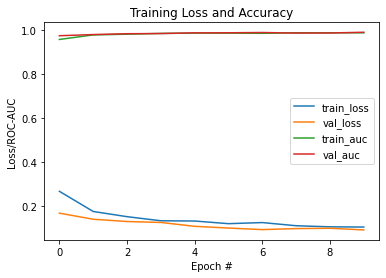

In [19]:
# vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

N = Epochs
# plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["auc"], label="train_auc")
plt.plot(np.arange(0, N), H.history["val_auc"], label="val_auc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ROC-AUC")
plt.legend(loc="center right")

# 5. Kiểm tra mô hình

Nhắc lại, quá trình nhận diện một gương mặt có đeo khẩu trang hay không được thực hiện theo từng bước sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Trong phần này chúng ta sẽ thực hiện việc kiểm tra mô hình nhận diện đeo khẩu trang. Về phần nhận diện gương mặt chúng ta sẽ sử dụng mô hình MTCNN với các hàm và thư viện mà chúng ta đã cung cấp sẵn

- Import các thư viện cần thiết cho việc kiểm tra

In [20]:
import cv2
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector
from tensorflow.keras.models import load_model

- Sử dụng hàm nhận diện gương mặt có sẵn đã được cung cấp để tiến hành Face Detection và Face Alignment trước khi nhận diện khẩu trang.

**Lưu ý**: Hàm này có thể không hoạt động được và trả về lỗi nếu trong bức ảnh không có gương mặt nào hoặc trong một vài trường hợp không thể nhận diện được ảnh trong gương mặt

**Có thể học viên sẽ thắc mắc tại sao chúng ta phải sử dụng Face Alignemnt?**

Đúng như tên gọi của nó: Alignment (sự căn chỉnh), Face Alignment giúp khuôn mặt dù có bị quay ngang, bị chéo mặt hay thậm chị bị mất nhiều chi tiết do điều kiện ngoại cảnh, lệch ra khỏi khung hình... cũng có thể "căn chỉnh" lại về trung tâm bức ảnh với hướng mặt thẳng chính giữa như mong muốn được. Sau bước detection thì các khuôn mặt của chúng ta có thể ở các trạng thái khác nhau hoặc các góc độ khác nhau, có những khuôn mặt bị chéo và cũng có thể bị lệch do bước detect chưa chính xác trong việc lấy ra khung hình chuẩn của mặt. Thì việc áp dụng Face Alignment ở đây là cần thiết, nó có thể hiểu như một hình thức của data normalization (chuẩn hóa dữ liệu), giúp tiêu chuẩn hoá lại dữ liệu trước khi đưa vào mô hình phân loại (binary classcification), điều này giúp cho mô hình có kết quả dự đoán chính xác hơn. Học viên có thể so sánh với **mô hình chỉ có Face Detection mà không có Face Alignment** với mô hình ở phía dưới để so sánh kết quả xem liệu sự có mặt của Face Alignment liệu thật sự có cải thiện kết quả hay không.

In [21]:
detector = MtcnnDetector()

def face_detection(img, output_size, align = False):
    """Nếu align == True thì sẽ có thêm bước Face Alignment sau khi nhận diện gương mặt,
        ngược lại thì không có thêm bước này"""
    
    # Nhận diện gương mặt
    boxes, facial5points = detector.detect_faces(img)
    
    # Tiến hành Alignment
    if align == True:
        if len(facial5points) != 0:
            facial5points = np.reshape(facial5points[0], (2, 5))

            default_square = True
            inner_padding_factor = 0.25
            outer_padding = (0, 0)

            ## Yêu cầu 10:
            ## VIẾT CODE Ở ĐÂY:

            # sử dụng hàm get_reference_facial_points
            reference_5pts = get_reference_facial_points(
                output_size, inner_padding_factor, outer_padding, default_square)
            
            # sử dụng hàm warp_and_crop_face
            face = warp_and_crop_face(img, facial5points, reference_pts = reference_5pts, crop_size = output_size)
               
    # Không Alignment
    else:
        (h,w) = img.shape[:2]
        if len(boxes) != 0:
            for box in boxes:
                (startX, startY, endX, endY) = box[:4].astype('int')
                (startX, startY) = (max(0, startX),max(0, startY))
                (endX, endY) = (min(w-1, endX), min(h-1, endY))
                face = img[startY:endY, startX:endX]
                face = cv2.resize(face, output_size)
                
    return face

- Tạo ra mảng chứa các ảnh sau đã thực hiện việc nhận diện gương mặt

In [22]:
test_X_align = test_X.copy()

- Như đã lưu ý ở trên, có thể có một vài bức ảnh không thể nhận diện gương mặt được với hàm này, cho nên chúng ta sẽ chỉ lựa chọn ra các bức ảnh chỉ nhận diện được và lưu chỉ mục của chúng vào mảng **choose**. Sử dụng cấu trúc **try-except** để xử lý lỗi trong trường hợp này

In [23]:
choose = []

for i in range(len(test_X)):
    try:
        # Tiến hành nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224
        ## Yêu cầu 11:
        ## VIẾT CODE Ở ĐÂY:
        test_X_align[i] = face_detection(test_X[i].astype('uint8'), (224, 224), align = True)
        # Lưu chỉ mục của ảnh đã nhận diện thành công vào mảng choose
        choose.append(i)
    except:
        # Nếu tấm ảnh không nhận diện được thì chúng ta sẽ bỏ qua tấm này
        continue
        
choose = np.array(choose)

In [24]:
test_X_align.shape

(3200, 224, 224, 3)

In [25]:
test_X_align[choose, :, :, :].shape

(1349, 224, 224, 3)

- Chúng ta sẽ sử dụng chỉ số **ROC-AUC** làm chỉ số đánh giá mô hình

In [26]:
from sklearn.metrics import roc_auc_score

- Lọc ra các tấm ảnh với mảng choose và tiến hành tính chỉ số ROC-AUC

In [27]:
## Yêu cầu 12:
## VIẾT CODE Ở ĐÂY:
predict = model.predict(test_X_align[choose])
predict = np.argmax(predict, axis = 1)
roc_auc_score(test_Y[choose].argmax(axis = 1), predict)

43/43 [==============================] - 15s 326ms/step


0.9656540644661257

## 5.1 Multi-faces

Nếu ở phần trên chúng ta chỉ nhận diện tấm ảnh chỉ có một gương mặt duy nhất thì ở phần này chúng ta sẽ nhận diện nhiều gương mặt có đeo khẩu trang hay không trong cùng một bức ảnh với mô hình ở trên

- Sử dụng hàm có sẵn

In [28]:
def mask_detect(image):
    
    img = image.copy()
    (h,w) = img.shape[:2]
    boxes, facial5points = detector.detect_faces(img)
    for box in boxes:
        (startX,startY,endX,endY)=box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))

        (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)

        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)
        
    return img

- Nhận diện một vài bức ảnh có sẵn trong thư mục image

1/1 [==============================] - 0s 436ms/step


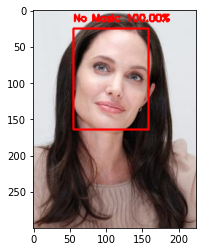

In [29]:
img = cv2.imread("image/angelina.jpg")
## Yêu cầu 13:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(False)
plt.show()
#cv2.imshow("OutPut",img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

1/1 [==============================] - 0s 29ms/step


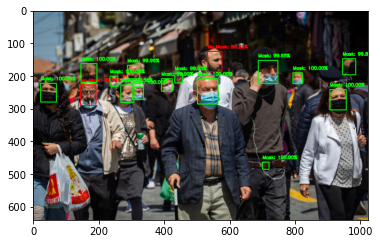

In [30]:
img = cv2.imread("image/people.jpg")
## Yêu cầu 14:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(False)
plt.show()
#cv2.imshow("OutPut",img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

1/1 [==============================] - 0s 31ms/step


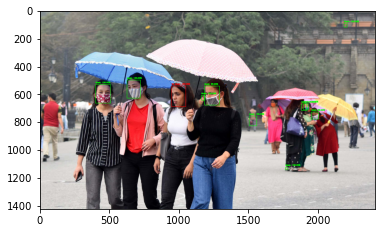

In [31]:
img = cv2.imread("image/woman.jpg")
## Yêu cầu 15:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(False)
plt.show()
#cv2.imshow("OutPut",img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

1/1 [==============================] - 0s 29ms/step


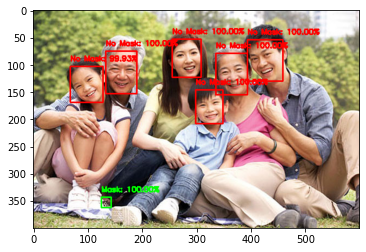

In [32]:
img = cv2.imread("image/family.jpg")
## Yêu cầu 16:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(False)
plt.show()
#cv2.imshow("OutPut",img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

## 5.2 Video

Ở phần này chúng ta sẽ nhận diện gương mặt đeo khẩu trang theo thời gian thực thông qua camera của máy tính

In [33]:
from imutils.video import VideoStream
import imutils

In [39]:
vs = cv2.VideoCapture(0)

while True:
    #grab the frame from the threaded video stream and resize it
    #to have a maximum width of 400 pixels
    frame = vs.read()[1]
    (h, w) = frame.shape[:2]
    boxes, facial5points = detector.detect_faces(frame)
    for box in boxes:
        (startX, startY, endX, endY) = box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX, startY) = (max(0, startX),max(0, startY))
        (endX, endY) = (min(w-1, endX), min(h-1, endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face = frame[startY:endY, startX:endX]
        face = cv2.resize(face,(224,224))

        (mask, withoutMask) = model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label = 'Mask' if mask > withoutMask else 'No Mask'
        color = (0, 255, 0) if label == 'Mask' else (0, 0, 255)

        #include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(frame, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        
    #show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):
        break
        
cv2.destroyAllWindows()

1/1 [==============================] - 0s 30ms/step


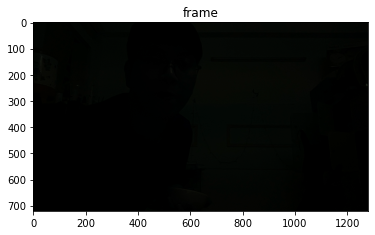

In [38]:
camera = cv2.VideoCapture(0)
ret, frame = camera.read()
plt.imshow(frame)
plt.title('frame')
plt.show()

In [40]:
vs.release()

# 6. Cải thiện mô hình

- Phần này học viên sẽ tự đề xuất và thực thi các phương pháp khác nhau nhằm mục đích cải thiện chất lượng mô hình tốt hơn có thể có. Tức là chỉ số **ROC-AUC >= 0.992**. Một số phương pháp được đề xuất như sau:

1. Cải thiện model nhận diện đeo khẩu trang.

2. Cải thiện model phát hiện khuôn mặt.

3. Sử dụng thêm dữ liệu cho quá trình huấn luyện.

4. Cải thiện phần face alignment

In [ ]:
## Yêu cầu 17:
## VIẾT CODE Ở ĐÂY:

**17.1**  
*Cải thiện model nhận diện đeo khẩu trang*  
*Bỏ đóng băng 5 layers cuối của baseModel*  

In [33]:
# Khởi tạo model_1
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(units=128, activation='relu')(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(units=2, activation='softmax')(headModel)

model_1 = Model(inputs = baseModel.input, outputs = headModel)

# Bỏ đóng băng tất cả layer trong baseModel
baseModel.trainable = True

# Đóng băng lại các layer, trừ 5 layers cuối
for layer in baseModel.layers[:-5]:
    layer.trainable = False

# Giảm learning rate còn 0.0001
learning_rate = 0.0001
Epochs = 10
BS = 40

# Khởi tạo thuật toán tối ưu Adam
opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, 
          decay=learning_rate/Epochs)
model_1.compile(loss='binary_crossentropy', optimizer = opt, metrics = ["AUC"])

L = model_1.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)


Epoch 1/10
100/100 [==============================] - 57s 549ms/step - loss: 0.3408 - auc: 0.9407 - val_loss: 0.1864 - val_auc: 0.9744
Epoch 2/10
100/100 [==============================] - 54s 539ms/step - loss: 0.1678 - auc: 0.9818 - val_loss: 0.1308 - val_auc: 0.9828
Epoch 3/10
100/100 [==============================] - 54s 540ms/step - loss: 0.1401 - auc: 0.9857 - val_loss: 0.0961 - val_auc: 0.9919
Epoch 4/10
100/100 [==============================] - 54s 542ms/step - loss: 0.1131 - auc: 0.9889 - val_loss: 0.0913 - val_auc: 0.9923
Epoch 5/10
100/100 [==============================] - 55s 544ms/step - loss: 0.0992 - auc: 0.9912 - val_loss: 0.0945 - val_auc: 0.9910
Epoch 6/10
100/100 [==============================] - 54s 544ms/step - loss: 0.0986 - auc: 0.9908 - val_loss: 0.0917 - val_auc: 0.9914
Epoch 7/10
100/100 [==============================] - 55s 549ms/step - loss: 0.0838 - auc: 0.9926 - val_loss: 0.0759 - val_auc: 0.9934
Epoch 8/10
100/100 [==============================] - 5

In [34]:
# Sử dụng chỉ số roc-auc, đánh giá model_1
predict_1 = model_1.predict(test_X_align[choose])
predict_1 = np.argmax(predict_1, axis = 1)
roc_auc_score(test_Y[choose].argmax(axis = 1), predict_1)

43/43 [==============================] - 15s 329ms/step


0.964819173429379

**17.2**  
*Thêm dữ liệu cho training set*

In [35]:
# Khởi tạo list rỗng: chứa các bức ảnh
data_2 = []

# khởi tạo list rỗng: chứa các nhãn của bức ảnh 
labels_2 = []

# Sử dụng các ảnh còn lại trong dataset
for i in imagePaths[4000:-4000]:
    
    label = i.split(os.path.sep)[-2]
    # Chèn các dữ liệu nhãn vào list labels
    labels_2.append(label)
    
    # Sử dụng hàm load_img để tạo mảng chứ dữ liệu tấm ảnh với kích thước 224 x 224
    image = load_img(i, target_size = (224, 224)) 
    image = img_to_array(image)
    # Chèn các dữ liệu ảnh vào list data
    data_2.append(image)
    
# mã hóa list dữ liệu thành định dạng mảng NumPy    
data_2 = np.array(data_2,dtype='float32')
labels_2 = np.array(labels_2)

# Sử dụng LabelBinarizer để mã hóa mảng labels
# Mã hóa nhị phân cho 2 loại nhãn
lb = LabelBinarizer()
labels_2 = lb.fit_transform(labels_2)
# Chuyển từng nhãn sau khi đã mã hóa thành từng vector nhị phân tương ứng
labels_2 = to_categorical(labels_2)

# Thêm dữ liệu vào training set
train_X_new = np.concatenate((train_X, data_2))
train_Y_new = np.concatenate((train_Y, labels_2))

/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [36]:
# Khởi tạo model_2, huấn luyện bằng training set mới (train_X_new, train_Y_new)

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(units=128, activation='relu')(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(units=2, activation='softmax')(headModel)

model_2 = Model(inputs = baseModel.input, outputs = headModel)

# Đóng băng lại các layer của baseModel
for layer in baseModel.layers:
    layer.trainable = False

learning_rate = 0.001
Epochs = 10
BS = 40

# Khởi tạo thuật toán tối ưu Adam
opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate,
          decay=learning_rate/Epochs)
model_2.compile(loss='binary_crossentropy', optimizer = opt, metrics = ["AUC"])

A = model_2.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X_new, train_Y_new, batch_size = BS),
    steps_per_epoch = len(train_X_new)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)


Epoch 1/10
511/511 [==============================] - 243s 468ms/step - loss: 0.1071 - auc: 0.9883 - val_loss: 0.0762 - val_auc: 0.9937
Epoch 2/10
511/511 [==============================] - 236s 462ms/step - loss: 0.0743 - auc: 0.9926 - val_loss: 0.0869 - val_auc: 0.9911
Epoch 3/10
511/511 [==============================] - 236s 461ms/step - loss: 0.0637 - auc: 0.9936 - val_loss: 0.0804 - val_auc: 0.9902
Epoch 4/10
511/511 [==============================] - 236s 462ms/step - loss: 0.0599 - auc: 0.9943 - val_loss: 0.0661 - val_auc: 0.9942
Epoch 5/10
511/511 [==============================] - 236s 462ms/step - loss: 0.0518 - auc: 0.9951 - val_loss: 0.0614 - val_auc: 0.9943
Epoch 6/10
511/511 [==============================] - 238s 465ms/step - loss: 0.0486 - auc: 0.9955 - val_loss: 0.0708 - val_auc: 0.9942
Epoch 7/10
511/511 [==============================] - 239s 467ms/step - loss: 0.0454 - auc: 0.9961 - val_loss: 0.0736 - val_auc: 0.9918
Epoch 8/10
511/511 [============================

In [37]:
# Tiến hành tính chỉ số ROC-AUC
predict_2 = model_2.predict(test_X_align[choose])
predict_2 = np.argmax(predict_2, axis = 1)
roc_auc_score(test_Y[choose].argmax(axis = 1), predict_2)

43/43 [==============================] - 15s 333ms/step


0.9782728868423451

**17.3**  
*Bỏ đóng băng 5 layers cuối của baseModel*  
*Dùng dữ liệu training set mới: train_X_new, train_Y_new*

In [38]:
# Khởi tạo model_3
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(units=128, activation='relu')(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(units=2, activation='softmax')(headModel)

model_3 = Model(inputs = baseModel.input, outputs = headModel)

# Bỏ đóng băng tất cả layer trong baseModel
baseModel.trainable = True

# Đóng băng lại các layer, trừ 5 layers cuối
for layer in baseModel.layers[:-5]:
    layer.trainable = False

# Giảm learning rate còn 0.0001
learning_rate = 0.0001
Epochs = 10
BS = 40

# Khởi tạo thuật toán tối ưu Adam
opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, 
          decay=learning_rate/Epochs)
model_3.compile(loss='binary_crossentropy', optimizer = opt, metrics = ["AUC"])

B = model_3.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X_new, train_Y_new, batch_size = BS),
    steps_per_epoch = len(train_X_new)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)


Epoch 1/10
511/511 [==============================] - 258s 500ms/step - loss: 0.1151 - auc: 0.9899 - val_loss: 0.0707 - val_auc: 0.9915
Epoch 2/10
511/511 [==============================] - 257s 502ms/step - loss: 0.0644 - auc: 0.9944 - val_loss: 0.0607 - val_auc: 0.9942
Epoch 3/10
511/511 [==============================] - 252s 494ms/step - loss: 0.0518 - auc: 0.9960 - val_loss: 0.0535 - val_auc: 0.9933
Epoch 4/10
511/511 [==============================] - 247s 483ms/step - loss: 0.0433 - auc: 0.9962 - val_loss: 0.0499 - val_auc: 0.9947
Epoch 5/10
511/511 [==============================] - 253s 494ms/step - loss: 0.0382 - auc: 0.9966 - val_loss: 0.0556 - val_auc: 0.9934
Epoch 6/10
511/511 [==============================] - 247s 483ms/step - loss: 0.0349 - auc: 0.9972 - val_loss: 0.0531 - val_auc: 0.9946
Epoch 7/10
511/511 [==============================] - 252s 492ms/step - loss: 0.0285 - auc: 0.9980 - val_loss: 0.0417 - val_auc: 0.9949
Epoch 8/10
511/511 [============================

In [39]:
predict_3 = model_3.predict(test_X_align[choose])
predict_3 = np.argmax(predict_3, axis = 1)
roc_auc_score(test_Y[choose].argmax(axis = 1), predict_3)

43/43 [==============================] - 15s 331ms/step


0.9751826502233976

**17.4**  
*Bỏ đóng băng 10 layers cuối của baseModel*  
*Dùng dữ liệu training set ban đầu: train_X, train_Y*

In [40]:
# Khởi tạo model_4
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(units=128, activation='relu')(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(units=2, activation='softmax')(headModel)

model_4 = Model(inputs = baseModel.input, outputs = headModel)

# Bỏ đóng băng tất cả layer trong baseModel
baseModel.trainable = True

# Đóng băng lại các layer, trừ 10 layers cuối
for layer in baseModel.layers[:-10]:
    layer.trainable = False

# Giảm learning rate còn 0.0001
learning_rate = 0.0001
Epochs = 10
BS = 40

# Khởi tạo thuật toán tối ưu Adam
opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, 
          decay=learning_rate/Epochs)
model_4.compile(loss='binary_crossentropy', optimizer = opt, metrics = ["AUC"])

I = model_4.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)


Epoch 1/10
100/100 [==============================] - 61s 582ms/step - loss: 0.1535 - auc: 0.9904 - val_loss: 0.0606 - val_auc: 0.9940
Epoch 2/10
100/100 [==============================] - 56s 555ms/step - loss: 0.0522 - auc: 0.9971 - val_loss: 0.0573 - val_auc: 0.9930
Epoch 3/10
100/100 [==============================] - 55s 550ms/step - loss: 0.0417 - auc: 0.9972 - val_loss: 0.0505 - val_auc: 0.9944
Epoch 4/10
100/100 [==============================] - 55s 551ms/step - loss: 0.0414 - auc: 0.9965 - val_loss: 0.0478 - val_auc: 0.9946
Epoch 5/10
100/100 [==============================] - 55s 550ms/step - loss: 0.0353 - auc: 0.9976 - val_loss: 0.0502 - val_auc: 0.9946
Epoch 6/10
100/100 [==============================] - 56s 554ms/step - loss: 0.0299 - auc: 0.9983 - val_loss: 0.0573 - val_auc: 0.9922
Epoch 7/10
100/100 [==============================] - 55s 550ms/step - loss: 0.0204 - auc: 0.9996 - val_loss: 0.0595 - val_auc: 0.9933
Epoch 8/10
100/100 [==============================] - 5

In [41]:
predict_4 = model_4.predict(test_X_align[choose])
predict_4 = np.argmax(predict_4, axis = 1)
roc_auc_score(test_Y[choose].argmax(axis = 1), predict_4)

43/43 [==============================] - 15s 329ms/step


0.9793599548645937

**17.5**  
*Bỏ đóng băng 10 layers cuối của baseModel*  
*Dùng dữ liệu training set mới: train_X_new, train_Y_new*

In [42]:
# Khởi tạo model_5
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(units=128, activation='relu')(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(units=2, activation='softmax')(headModel)

model_5 = Model(inputs = baseModel.input, outputs = headModel)

# Bỏ đóng băng tất cả layer trong baseModel
baseModel.trainable = True

# Đóng băng lại các layer, trừ 10 layers cuối
for layer in baseModel.layers[:-10]:
    layer.trainable = False

# Giảm learning rate còn 0.0001
learning_rate = 0.0001
Epochs = 10
BS = 40

# Khởi tạo thuật toán tối ưu Adam
opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, 
          decay=learning_rate/Epochs)
model_5.compile(loss='binary_crossentropy', optimizer = opt, metrics = ["AUC"])

T = model_5.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X_new, train_Y_new, batch_size = BS),
    steps_per_epoch = len(train_X_new)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)


Epoch 1/10
511/511 [==============================] - 260s 505ms/step - loss: 0.0589 - auc: 0.9968 - val_loss: 0.0606 - val_auc: 0.9933
Epoch 2/10
511/511 [==============================] - 253s 495ms/step - loss: 0.0300 - auc: 0.9977 - val_loss: 0.0440 - val_auc: 0.9961
Epoch 3/10
511/511 [==============================] - 253s 495ms/step - loss: 0.0254 - auc: 0.9981 - val_loss: 0.0519 - val_auc: 0.9961
Epoch 4/10
511/511 [==============================] - 252s 493ms/step - loss: 0.0227 - auc: 0.9984 - val_loss: 0.0468 - val_auc: 0.9962
Epoch 5/10
511/511 [==============================] - 250s 489ms/step - loss: 0.0203 - auc: 0.9982 - val_loss: 0.0471 - val_auc: 0.9962
Epoch 6/10
511/511 [==============================] - 248s 484ms/step - loss: 0.0171 - auc: 0.9988 - val_loss: 0.0480 - val_auc: 0.9961
Epoch 7/10
511/511 [==============================] - 249s 487ms/step - loss: 0.0175 - auc: 0.9984 - val_loss: 0.0513 - val_auc: 0.9961
Epoch 8/10
511/511 [============================

In [43]:
predict_5 = model_5.predict(test_X_align[choose])
predict_5 = np.argmax(predict_5, axis = 1)
roc_auc_score(test_Y[choose].argmax(axis = 1), predict_5)

43/43 [==============================] - 15s 328ms/step


0.9806963504148811

**17.6**  
*Bỏ đóng băng 15 layers cuối của baseModel*  
*Dùng dữ liệu training set mới: train_X_new, train_Y_new*

In [49]:
# Khởi tạo model_6
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(units=128, activation='relu')(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(units=2, activation='softmax')(headModel)

model_6 = Model(inputs = baseModel.input, outputs = headModel)

# Bỏ đóng băng tất cả layer trong baseModel
baseModel.trainable = True

# Đóng băng lại các layer, trừ 15 layers cuối
for layer in baseModel.layers[:-15]:
    layer.trainable = False

# Giảm learning rate còn 0.00001
learning_rate = 0.00001
Epochs = 20
BS = 40

# Khởi tạo thuật toán tối ưu Adam
opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, 
          decay=learning_rate/Epochs)
model_6.compile(loss='binary_crossentropy', optimizer = opt, metrics = ["AUC"])

J = model_6.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X_new, train_Y_new, batch_size = BS),
    steps_per_epoch = len(train_X_new)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)


Epoch 1/20
511/511 [==============================] - 279s 539ms/step - loss: 0.2996 - auc: 0.9708 - val_loss: 0.0883 - val_auc: 0.9944
Epoch 2/20
511/511 [==============================] - 268s 524ms/step - loss: 0.0926 - auc: 0.9968 - val_loss: 0.0633 - val_auc: 0.9953
Epoch 3/20
511/511 [==============================] - 267s 523ms/step - loss: 0.0613 - auc: 0.9975 - val_loss: 0.0584 - val_auc: 0.9955
Epoch 4/20
511/511 [==============================] - 268s 525ms/step - loss: 0.0485 - auc: 0.9979 - val_loss: 0.0543 - val_auc: 0.9957
Epoch 5/20
511/511 [==============================] - 270s 527ms/step - loss: 0.0419 - auc: 0.9979 - val_loss: 0.0512 - val_auc: 0.9958
Epoch 6/20
511/511 [==============================] - 267s 522ms/step - loss: 0.0361 - auc: 0.9983 - val_loss: 0.0497 - val_auc: 0.9959
Epoch 7/20
511/511 [==============================] - 267s 523ms/step - loss: 0.0351 - auc: 0.9977 - val_loss: 0.0488 - val_auc: 0.9959
Epoch 8/20
511/511 [============================

In [50]:
predict_6 = model_6.predict(test_X_align[choose])
predict_6 = np.argmax(predict_6, axis = 1)
roc_auc_score(test_Y[choose].argmax(axis = 1), predict_6)

43/43 [==============================] - 15s 330ms/step


0.9883001276556943